In [1]:
import os   #used for directory work
import matplotlib.patches as mpatches #used for plot legends
import matplotlib.pyplot as plt   #used for creating plots
import pandas as pd
import numpy as np
from Raw_Cleaner import timestamp_matcher, cutter

In [2]:
def file_to_df(path, file, f_skrow=4,h_skrow=1,raw=True):
    """
    This function takes in a path to a file then adds the correct headers 
    and makes the Timestamp the index and returns the dataframe
    
    inputs:
        path - directory of file
        file - wanted file to read in
        f_skrow - how many rows to skip for the data (default =  4)
        h_skrow - what row is the column names located
        raw - True if the timestamp is in the correct format
    output:
        df - pandas dataframe a usable format
    """    
    df = pd.read_csv(path+file, skiprows=f_skrow, na_values='NAN')
    headers_df = pd.read_csv(path+file,skiprows=h_skrow,nrows = 0)
    
    df.columns=list(headers_df)  #set the column names
    if raw:
        df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
    df.fillna(value=np.nan, inplace=True)

    #df =df.set_index("TIMESTAMP")
    return(df)

In [3]:
def day_trimmer(df, t_s, t_e):
    mask =(df['TIMESTAMP'] > t_s) & (df['TIMESTAMP'] < t_e) 
    df=df.loc[mask]
    return(df)

def wind_speed(df,num):
    U, V = list(df["Ux_"+str(num)]),list(df["Uy_"+str(num)])
    S = np.full(len(df),np.nan)
    for i in range(len(df)):
        
        S[i] = np.sqrt(U[i]**2+ V[i]**2)
    return S

def wind_direction(df,num):
    D = np.arctan2(-1*df["Uy_"+str(num)],-1*df["Ux_"+str(num)])*(180/np.pi)+180
    return D

In [4]:

def dataframe_trimmer(path,day_start,day_end):

    sonic_files =["TOA5_4976.ts_data.dat","TOA5_4975.ts_data.dat","TOA5_11585.ts_data.dat",\
                "TOA5_2879.ts_data.dat" ]


    df_4976 = day_trimmer(file_to_df(path, sonic_files[0]),day_start,day_end)
    df_4975 = day_trimmer(file_to_df(path, sonic_files[1]),day_start,day_end)
    df_11585 = day_trimmer(file_to_df(path, sonic_files[2]),day_start,day_end)
    df_2879 = day_trimmer(file_to_df(path, sonic_files[3]),day_start,day_end)

    df_names = [df_4976, df_4975, df_11585, df_2879]

    t_s,t_e = timestamp_matcher(df_names,sonic_files)    
    #t_s = "2019-05-20 13:24:07.5"
    df_4976 = cutter(df_4976, t_s, t_e)
    df_4975 = cutter(df_4975, t_s, t_e)
    df_11585 = cutter(df_11585, t_s, t_e)
    df_2879 = cutter(df_2879, t_s, t_e)

    df_names = [df_4976, df_4975, df_11585, df_2879]
    for df in range(len(df_names)):
        df_names[df] = remove_diag(df_names[df])
    return df_names


In [9]:
#columns = ["Ux_1","Uy_1","Uz_1","Ts_1","diag_rmy_1","Ux_2","Uy_2","Uz_2","Ts_2","diag_rmy_2","Ux_3","Uy_3","Uz_3","Ts_3","diag_rmy_3","Ux_4","Uy_4","Uz_4","Ts_4","diag_rmy_4"]
def remove_diag(df):
    for j in range(1,5):
        for i in range(len(df)):
            if df["diag_rmy_"+str(j)][i] != 0.0:
                df.at[i,["Ux_"+str(j),"Uy_"+str(j),"Uz_"+str(j),"Ts_"+str(j)]] = np.nan
    return df

In [6]:
def plotter(df_names,burn,temp_y_min = 27,temp_y_max = 37):
    fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(28,16))

    ax1 = axs[0]
    for i in range(len(df_names)):
        for j in range(1,5):
            ax1.plot(df_names[i]["TIMESTAMP"],df_names[i]["Ts_"+str(j)],linewidth = .05)

    ax1.set_ylim(temp_y_min,temp_y_max)
    ax1.grid()
    ax1.set_title("Temperature "+str(burn))
    ax1.set_xlim(df_names[0]["TIMESTAMP"][0],df_names[0]["TIMESTAMP"][len(df_names[0])-1])

    ax2 = axs[1]
    for i in range(len(df_names)):
        for j in range(1,5):
            ax2.plot(df_names[i]["TIMESTAMP"],wind_direction(df_names[i],j),linewidth = .05)

    ax2.grid()
    ax2.set_title("Wind Direction for Burn "+str(burn))
    ax2.set_xlim(df_names[0]["TIMESTAMP"][0],df_names[0]["TIMESTAMP"][len(df_names[0])-1])
    ax2.set_ylim(0)

    ax3 = axs[2]    
    for i in range(len(df_names)):
        for j in range(1,5):
            ax3.plot(df_names[i]["TIMESTAMP"],wind_speed(df_names[i],j),linewidth = .05)

    ax3.grid()
    ax3.set_title("Wind Speed Burn "+str(burn))
    ax3.set_xlim(df_names[0]["TIMESTAMP"][0],df_names[0]["TIMESTAMP"][len(df_names[0])-1])
    ax3.set_ylim(0,6)
    #plt.show()
    fig.savefig("Rough_Analysis_of_"+str(burn), dpi = 300)

File: TOA5_4976.ts_data.dat | Start: 2019-05-20 13:15:28.500000 | End: 2019-05-20 18:23:24.200000
File: TOA5_4975.ts_data.dat | Start: 2019-05-20 12:18:14 | End: 2019-05-20 18:21:34.300000
File: TOA5_11585.ts_data.dat | Start: 2019-05-20 11:17:45.300000 | End: 2019-05-20 18:19:42.600000
File: TOA5_2879.ts_data.dat | Start: 2019-05-20 12:51:42.200000 | End: 2019-05-20 18:17:30

Start timestamp Pulled: 2019-05-20 13:15:28.500000 | End Timestamp Pulled: 2019-05-20 18:17:30

Timestamp that can actually be used to trim due to gaps:
Start Time: 2019-05-20 13:24:07.500000 | End Time: 2019-05-20 18:15:28.500000


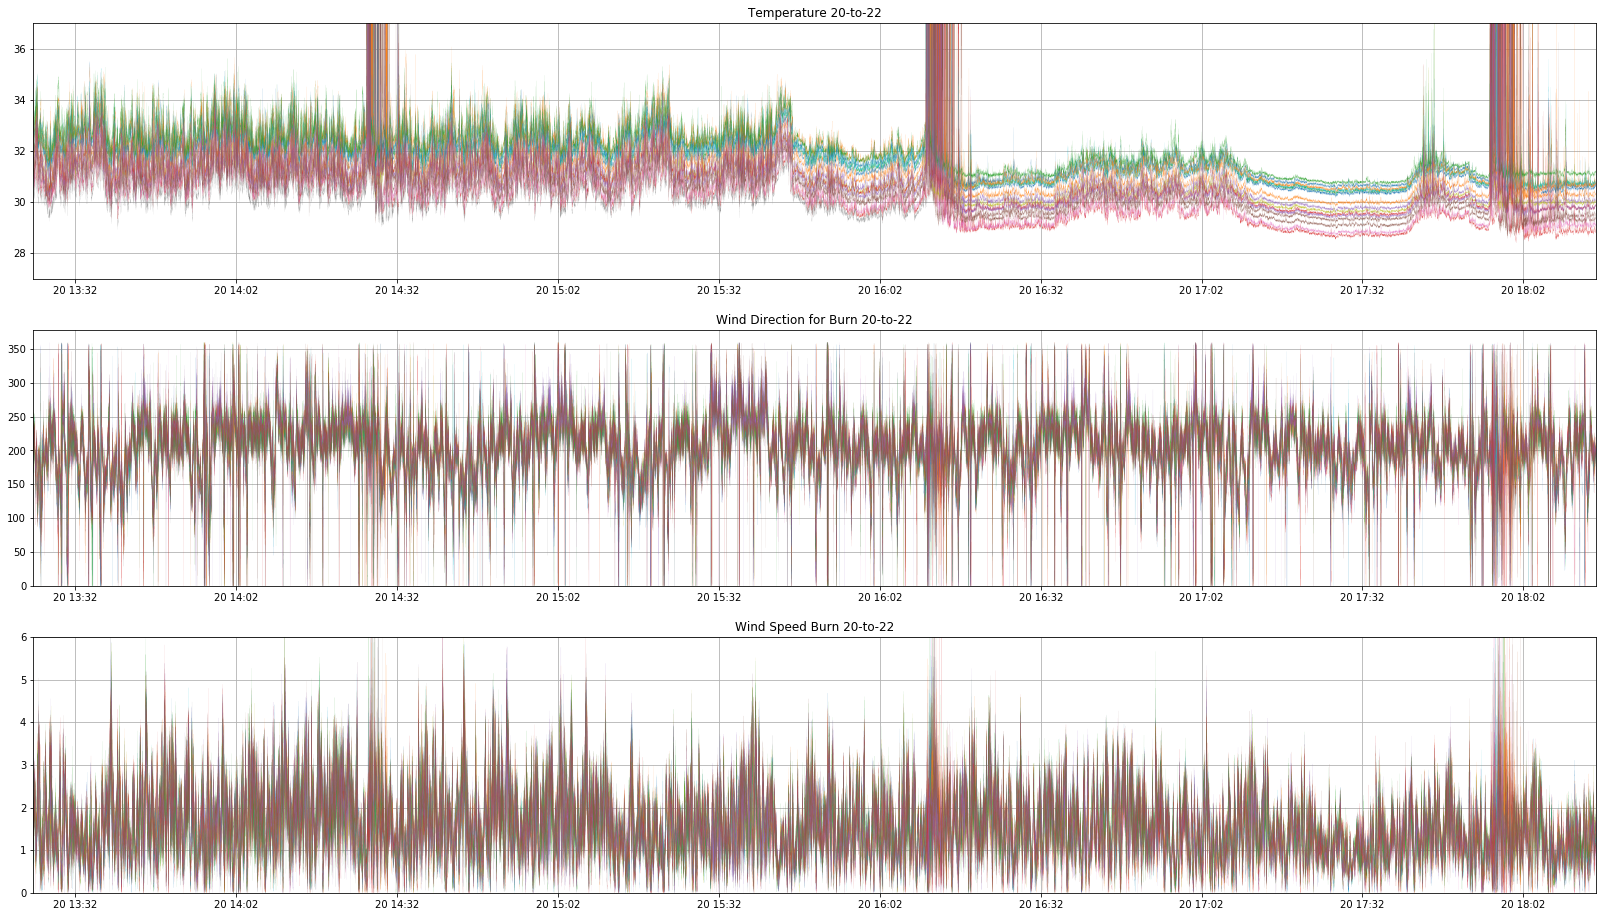

In [23]:
#p = "/home/joey/Desktop/10X10_Truss_SERDP_Burns/Raw-Sonic-TC-Data/SERDP-Burns-20-to-22/"
path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/Raw-Sonic-TC-Data/SERDP-Burns-20-to-22/"
day_start, day_end = "05-20-2019","05-21-2019"

plotter(dataframe_trimmer(path,day_start,day_end),"20-to-22")

File: TOA5_4976.ts_data.dat | Start: 2019-05-21 10:25:48.900000 | End: 2019-05-21 17:54:00
File: TOA5_4975.ts_data.dat | Start: 2019-05-21 10:27:19.300000 | End: 2019-05-21 17:52:09.400000
File: TOA5_11585.ts_data.dat | Start: 2019-05-21 10:47:11.900000 | End: 2019-05-21 17:48:28.500000
File: TOA5_2879.ts_data.dat | Start: 2019-05-21 10:41:34.600000 | End: 2019-05-21 17:46:11.600000

Start timestamp Pulled: 2019-05-21 10:47:11.900000 | End Timestamp Pulled: 2019-05-21 17:46:11.600000

Timestamp that can actually be used to trim due to gaps:
Start Time: 2019-05-21 10:47:11.900000 | End Time: 2019-05-21 17:42:11.900000


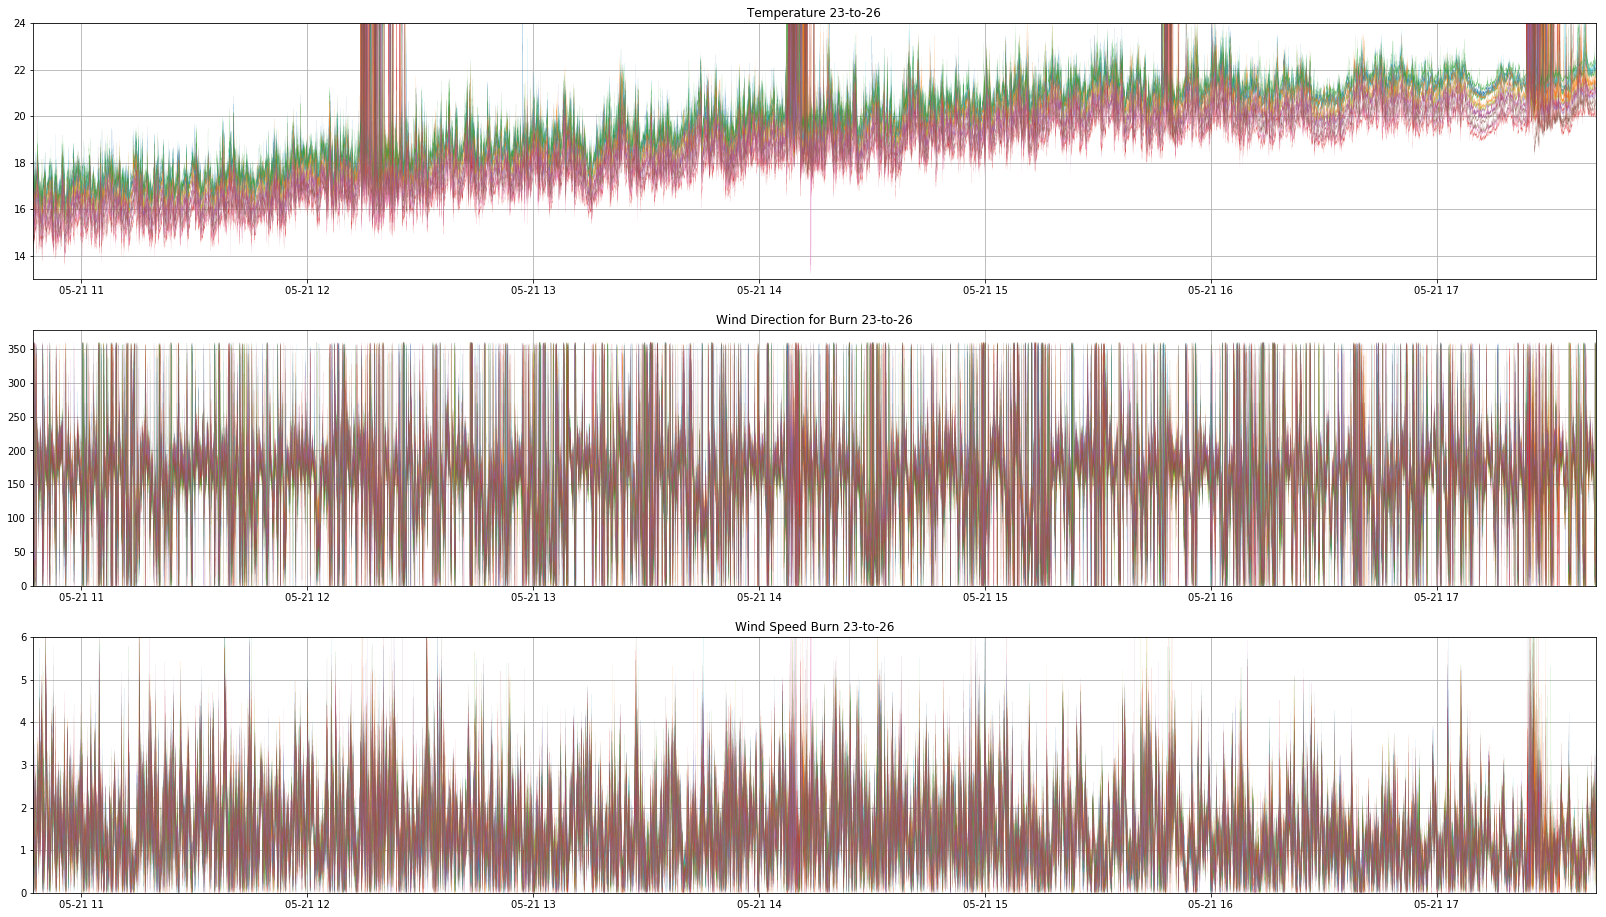

In [7]:
#p = "/home/joey/Desktop/10X10_Truss_SERDP_Burns/Raw-Sonic-TC-Data/SERDP-Burns-20-to-22/"
path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/Raw-Sonic-TC-Data/SERDP-Burns-23-to-26/"
day_start, day_end = "05-21-2019","05-22-2019"

plotter(dataframe_trimmer(path,day_start,day_end) ,"23-to-26",13,24) ## good limits

File: TOA5_4976.ts_data.dat | Start: 2019-05-22 09:04:50.700000 | End: 2019-05-22 16:18:05.800000
File: TOA5_4975.ts_data.dat | Start: 2019-05-22 08:53:54 | End: 2019-05-22 16:05:42.200000
File: TOA5_11585.ts_data.dat | Start: 2019-05-22 08:44:07.100000 | End: 2019-05-22 15:53:28.600000
File: TOA5_2879.ts_data.dat | Start: 2019-05-22 09:34:50.600000 | End: 2019-05-22 15:46:19.500000

Start timestamp Pulled: 2019-05-22 09:34:50.600000 | End Timestamp Pulled: 2019-05-22 15:46:19.500000

Timestamp that can actually be used to trim due to gaps:
Start Time: 2019-05-22 09:34:50.600000 | End Time: 2019-05-22 15:44:50.600000


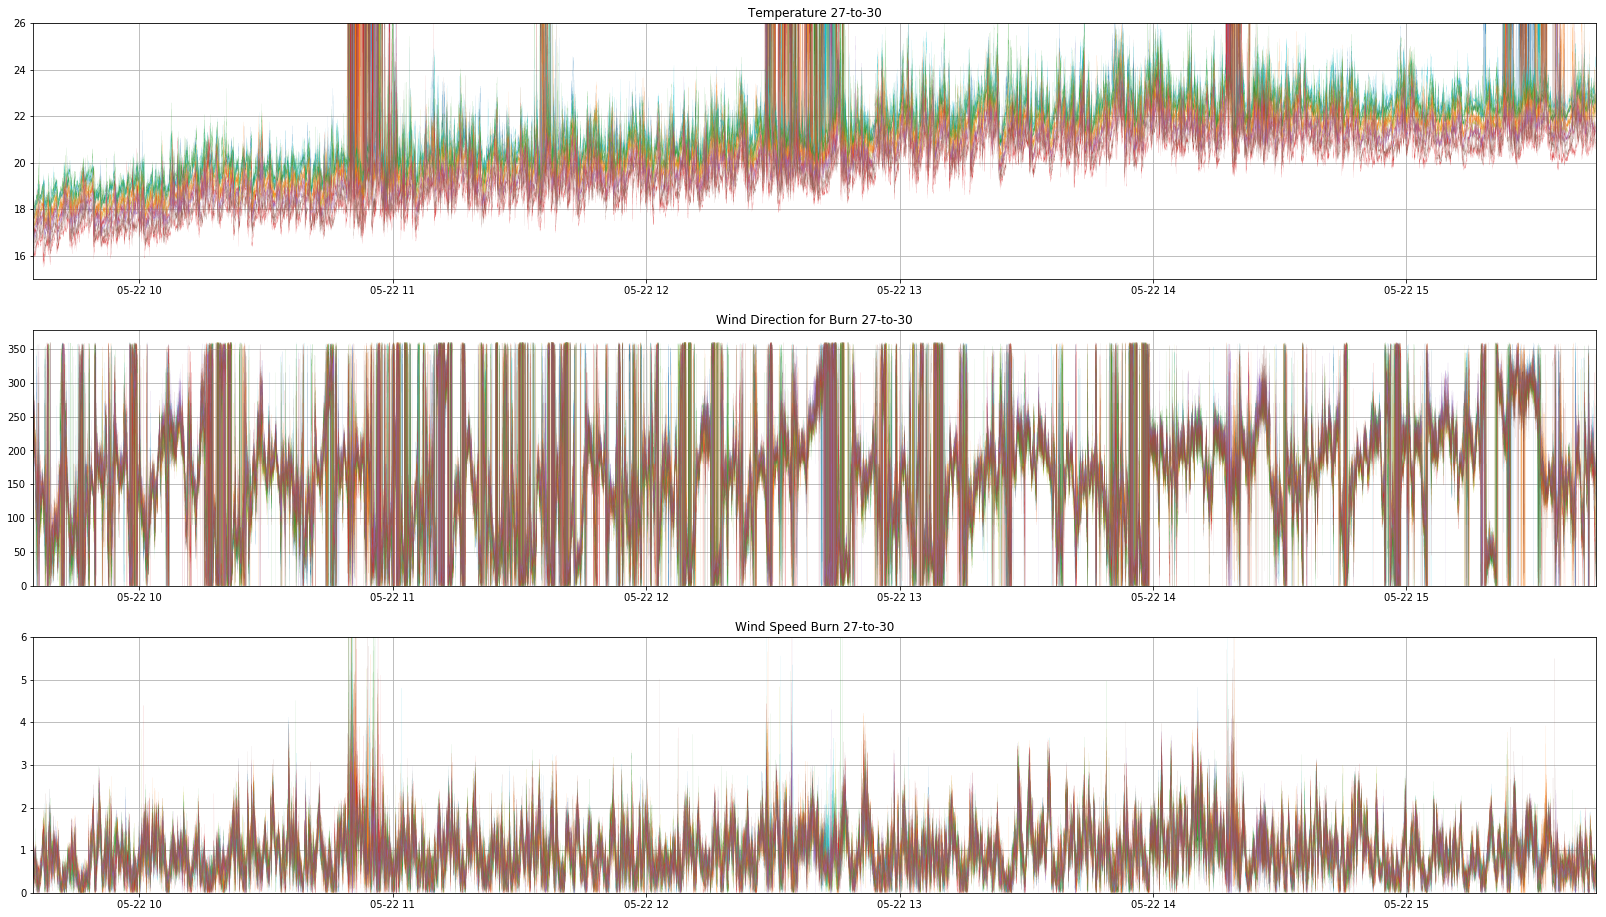

In [10]:
#p = "/home/joey/Desktop/10X10_Truss_SERDP_Burns/Raw-Sonic-TC-Data/SERDP-Burns-20-to-22/"
path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/Raw-Sonic-TC-Data/SERDP-Burns-27-to-30/"
day_start, day_end = "05-22-2019","05-23-2019"

plotter(dataframe_trimmer(path,day_start,day_end) ,"27-to-30",15,26) ### Good limits

File: TOA5_4976.ts_data.dat | Start: 2019-05-29 07:24:56.100000 | End: 2019-05-29 16:43:24.800000
File: TOA5_4975.ts_data.dat | Start: 2019-05-29 07:40:31.800000 | End: 2019-05-29 16:46:09
File: TOA5_11585.ts_data.dat | Start: 2019-05-29 08:52:20.900000 | End: 2019-05-29 16:38:41
File: TOA5_2879.ts_data.dat | Start: 2019-05-29 09:06:33.900000 | End: 2019-05-29 16:52:16.900000

Start timestamp Pulled: 2019-05-29 09:06:33.900000 | End Timestamp Pulled: 2019-05-29 16:38:41

Timestamp that can actually be used to trim due to gaps:
Start Time: 2019-05-29 09:06:33.900000 | End Time: 2019-05-29 16:36:33.900000


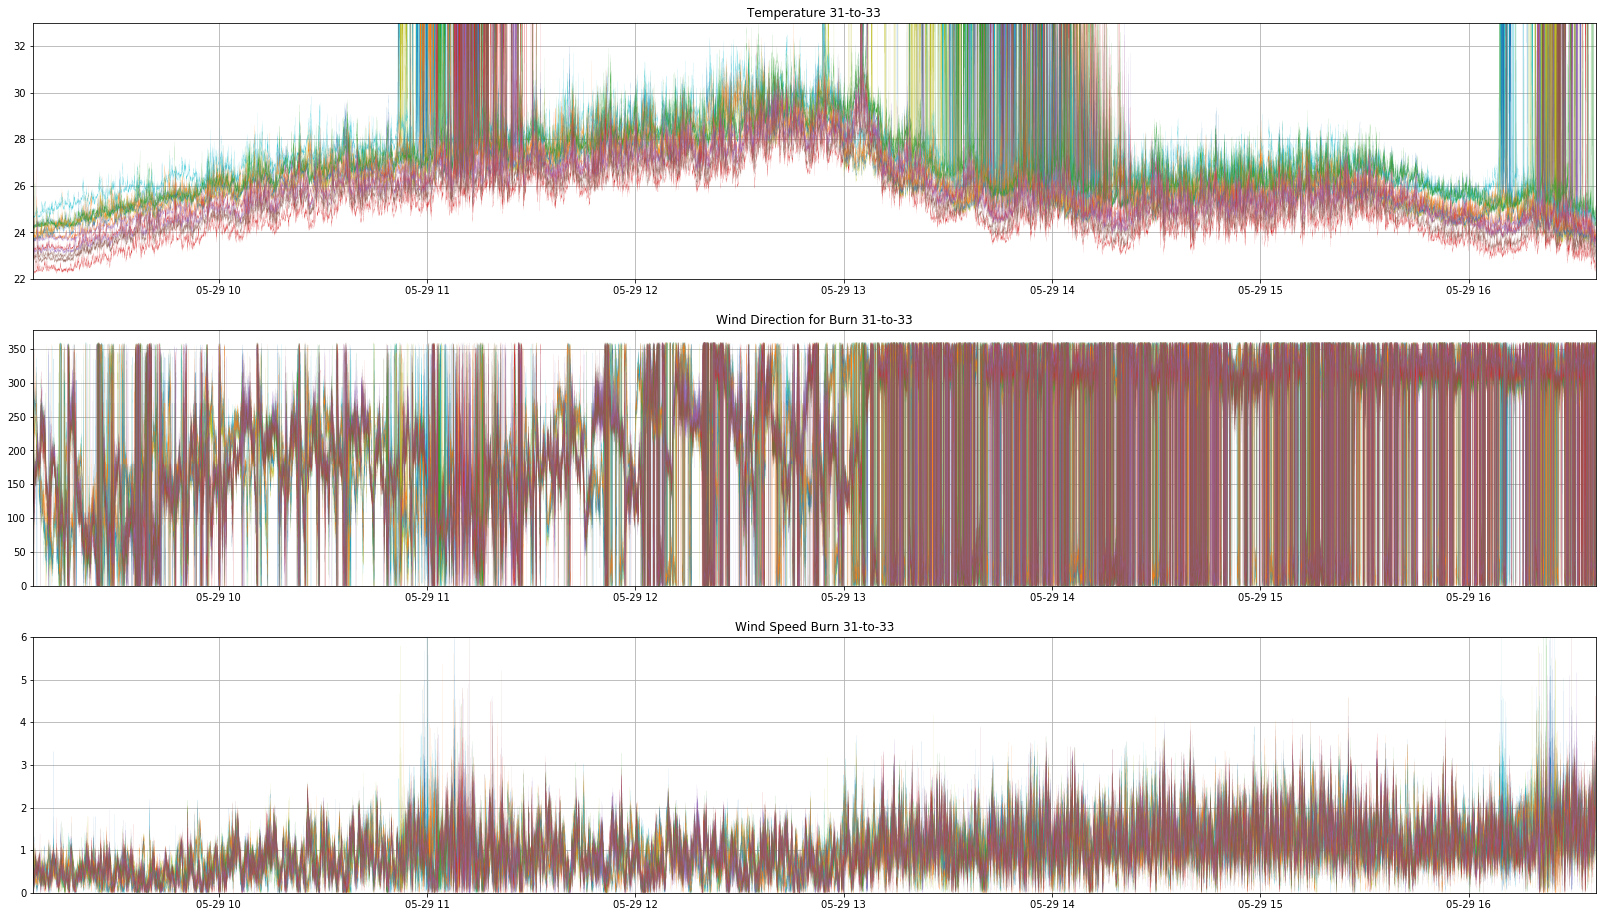

In [11]:
#p = "/home/joey/Desktop/10X10_Truss_SERDP_Burns/Raw-Sonic-TC-Data/SERDP-Burns-20-to-22/"
path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/Raw-Sonic-TC-Data/SERDP-Burns-31-to-33/"
day_start, day_end = "05-29-2019","05-30-2019"

plotter(dataframe_trimmer(path,day_start,day_end) ,"31-to-33",22,33) ## Good Limits

File: TOA5_4976.ts_data.dat | Start: 2019-05-31 07:05:28.600000 | End: 2019-05-31 13:19:20.700000
File: TOA5_4975.ts_data.dat | Start: 2019-05-31 07:11:01.500000 | End: 2019-05-31 13:22:28.400000
File: TOA5_11585.ts_data.dat | Start: 2019-05-31 07:27:22 | End: 2019-05-31 13:25:48
File: TOA5_2879.ts_data.dat | Start: 2019-05-31 07:22:10.600000 | End: 2019-05-31 13:28:05.200000

Start timestamp Pulled: 2019-05-31 07:27:22 | End Timestamp Pulled: 2019-05-31 13:19:20.700000

Timestamp that can actually be used to trim due to gaps:
Start Time: 2019-05-31 08:51:37 | End Time: 2019-05-31 13:17:22


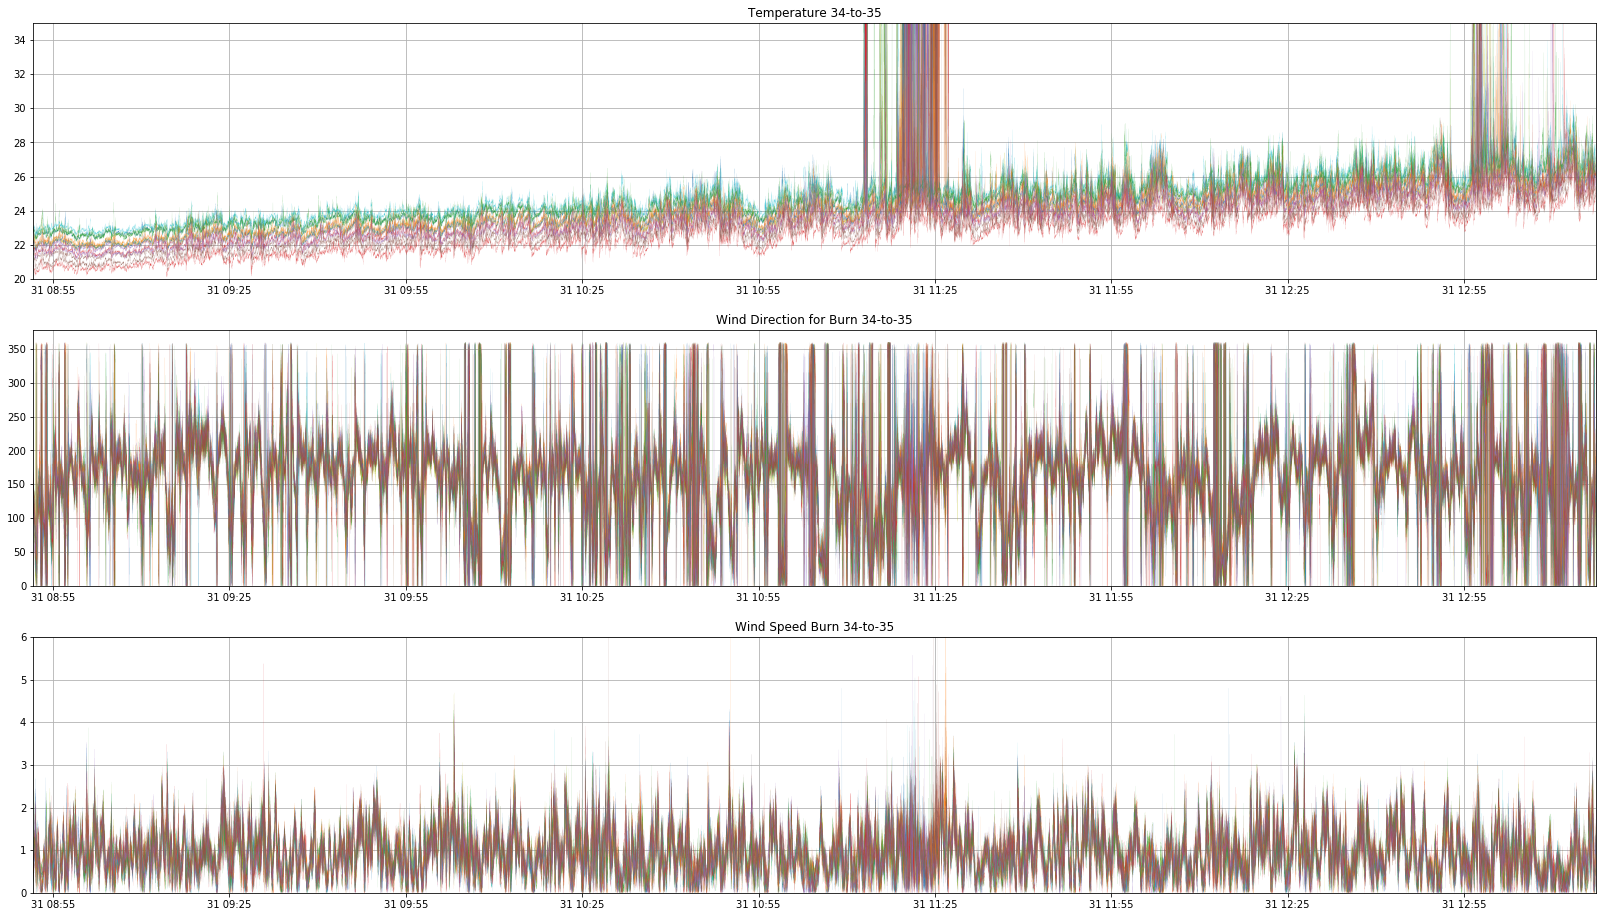

In [13]:
#p = "/home/joey/Desktop/10X10_Truss_SERDP_Burns/Raw-Sonic-TC-Data/SERDP-Burns-20-to-22/"
path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/Raw-Sonic-TC-Data/SERDP-Burns-34-to-35/"
day_start, day_end = "05-31-2019","06-01-2019"

plotter(dataframe_trimmer(path,day_start,day_end) ,"34-to-35",20,35)

In [ ]:
plt.figure(figsize = (18,8))
for i in range(len(df_names)):
    plt.plot(df_names[i]["TIMESTAMP"],df_names[i]["Ts_1"],linewidth = .05)
    plt.plot(df_names[i]["TIMESTAMP"],df_names[i]["Ts_2"],linewidth = .05)
    plt.plot(df_names[i]["TIMESTAMP"],df_names[i]["Ts_3"],linewidth = .05)
    plt.plot(df_names[i]["TIMESTAMP"],df_names[i]["Ts_4"],linewidth = .05)
plt.ylim(27,37)
plt.grid()

In [ ]:
plt.figure(figsize= (18,8))
#plt.plot(np.arctan2(-1*df_names[0]["Uy_1"],-1*df_names[0]["Ux_1"])*(180/np.pi)+180,linewidth = .5)

for i in range(len(df_names)):
    plt.plot(df_names[i]["TIMESTAMP"],wind_direction(df_names[i],1),linewidth = .05)
    plt.plot(df_names[i]["TIMESTAMP"],wind_direction(df_names[i],2),linewidth = .05)
    plt.plot(df_names[i]["TIMESTAMP"],wind_direction(df_names[i],3),linewidth = .05)
    plt.plot(df_names[i]["TIMESTAMP"],wind_direction(df_names[i],4),linewidth = .05)
plt.grid()
plt.title("Wind Direction for Burns 20-22")

In [ ]:
plt.figure(figsize = (18,8))
for i in range(len(df_names)):
    plt.plot(df_names[i]["TIMESTAMP"],wind_speed(df_names[i],1),linewidth = .05)
    plt.plot(df_names[i]["TIMESTAMP"],wind_speed(df_names[i],2),linewidth = .05)
    plt.plot(df_names[i]["TIMESTAMP"],wind_speed(df_names[i],3),linewidth = .05)
    plt.plot(df_names[i]["TIMESTAMP"],wind_speed(df_names[i],4),linewidth = .05)
plt.ylim(-1,6)
plt.grid()
plt.title("Wind Speed Burn 20-22")

In [ ]:
###### Lines for cutting

import os   #used for directory work
import matplotlib.patches as mpatches #used for plot legends
import matplotlib.pyplot as plt   #used for creating plots
import pandas as pd
import numpy as np
from Raw_Cleaner import timestamp_matcher, time_columns, file_to_df, cutter, \
    repeat, continuous_df 

In [ ]:
def day_trimmer(df, t_s, t_e):
    mask =(df['TIMESTAMP'] => t_s) & (df['TIMESTAMP'] <= t_e) 
    df=df.loc[mask]
    return(df)
def remove_diag(df):
    for j in range(1,5):
        for i in range(len(df)):
            if df["diag_rmy_"+str(j)][i] != 0.0:
                df.at[i,["Ux_"+str(j),"Uy_"+str(j),"Uz_"+str(j),"Ts_"+str(j)]] = np.nan
    return df

In [ ]:
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/Raw-Sonic-TC-Data/SERDP-Burns-20-to-22/" #w10
#path = "/home/joey/Desktop/10X10_Truss_SERDP_Burns/Raw-Sonic-TC-Data/SERDP-Burns-20-to-22/"  #79
#path = "/home/joey/Desktop/10X10_Truss_SERDP_Burns/Raw-Sonic-TC-Data/SERDP-Burns-23-to-26/"
path = "/home/joey/Desktop/10X10_Truss_SERDP_Burns/Raw-Sonic-TC-Data/SERDP-Burns-27-to-30/"
sonic_files =["TOA5_4976.ts_data.dat","TOA5_4975.ts_data.dat","TOA5_11585.ts_data.dat",\
                "TOA5_2879.ts_data.dat" ]

t_s,t_e = "2019-05-22 09:34:50.600000","2019-05-22 15:44:50.600000"
#df = cutter(file_to_df(path,sonic_files[0]),t_s,t_e)

In [ ]:
df_4976 =remove_diag(cutter(file_to_df(path,sonic_files[0]),t_s,t_e))
df_4975 =remove_diag(cutter(file_to_df(path,sonic_files[1]),t_s,t_e))
df_11585 =remove_diag(cutter(file_to_df(path,sonic_files[2]),t_s,t_e))
df_2879 = remove_diag(cutter(file_to_df(path,sonic_files[3]),t_s,t_e))

df_names = [df_4976, df_4975, df_11585, df_2879]


In [ ]:
#split_index=[ 0,85000,97000,153000,153001,211000,211001,249000]
#split_times = []
#for i in split_index:
#    split_times.append(df_4975["TIMESTAMP"][i])
    
fig, ax1 = plt.subplots(ncols= 1,nrows = 1,figsize=(18,6))

for i in range(len(df_names)):
    for j in range(1,5):
        ax1.plot(df_names[i]["TIMESTAMP"],df_names[i]["Ts_"+str(j)],linewidth = .05)
        #ax1.plot(df_names[i]["Ts_"+str(j)],linewidth = .05)
ax1.set_ylim(15,26)
ax1.grid()
ax1.set_title("Temperature for Burns 23-26",fontsize = 16)
#ax1.set_xlim(df_names[0]["TIMESTAMP"][0],df_names[0]["TIMESTAMP"][len(df_names[0])-1])
#ax1.set_xlim(60000)
ax1.vlines('2019-05-22 13:08:51.9',0,50)
ax1.set_ylabel(r"Temperature $\degree{C}$",fontsize = 16)
ax1.set_xlabel("Time (EST)",fontsize = 16)
#fig.text(.25,.8,"Burn 23")
#fig.text(.45,.8,"Burn 24")
#fig.text(.6,.8,"Burn 25")
#fig.text(.77,.8,"Burn 26")
plt.show()
#fig.savefig("Burns-27-to-30-Cut-Locations")

In [ ]:
#burn 23
df_4975["TIMESTAMP"][85000],df_4975["TIMESTAMP"][0]